# Install 

In [1]:
import math
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

from sklearn import metrics

import json
import urllib

from neuraxle.base import NonFittableMixin

from data_reading import DATASET_PATH, TRAIN, TEST, X_train_signals_paths, X_test_signals_paths, load_X, load_y, \
    TRAIN_FILE_NAME, TEST_FILE_NAME, LABELS

from neuraxle.api.flask import FlaskRestApiWrapper
from neuraxle.base import ExecutionContext, DEFAULT_CACHE_FOLDER, ExecutionMode, BaseStep

from neuraxle.hyperparams.space import HyperparameterSamples
from savers.tensorflow1_step_saver import TensorflowV1StepSaver
from neuraxle.steps.encoding import OneHotEncoder

from pipeline import HumanActivityRecognitionPipeline, BATCH_SIZE
from steps.custom_json_decoder_for_2darray import CustomJSONDecoderFor2DArray
from steps.custom_json_encoder_of_outputs import CustomJSONEncoderOfOutputs
from neuraxle.pipeline import MiniBatchSequentialPipeline, Joiner
from neuraxle.steps.output_handlers import OutputTransformerWrapper

# TODO: move in a package neuraxle-tensorflow 
from savers.tensorflow1_step_saver import TensorflowV1StepSaver
from neuraxle.pipeline import Pipeline


# Read Data

In [2]:
DATA_PATH = "data/"
DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"

# Load "X" (the neural network's training and testing inputs)

# X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# Load "y" (the neural network's training and testing outputs)

# y_train_path = os.path.join(DATASET_PATH, TRAIN, TRAIN_FILE_NAME)
y_test_path = os.path.join(DATASET_PATH, TEST, TEST_FILE_NAME)

# y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


# API Caller 

In [3]:
class APICaller(NonFittableMixin, BaseStep):
    def __init__(self, url):
        BaseStep.__init__(self)
        self.url = url
        
    def transform(self, data_inputs):
        data = json.dumps(np.array(data_inputs).tolist()).encode('utf8')
        req = urllib.request.Request(
            'http://127.0.0.1:5000/',
            method="GET",
            headers={'content-type': 'application/json'},
            data=data
        )
        response = urllib.request.urlopen(req)
        test_predictions = json.loads(response.read())
        return np.array(test_predictions['predictions'])

# Call Rest Api 

In [4]:
p = Pipeline([
    APICaller(url="http://localhost:5000/")
])
y_pred = p.transform(X_test)
print(y_pred)
# TODO: 
# y_test = y_test.argmax(1) ???? is this already made?

[[-0.03531179  0.18158735 -3.0826726   3.00903678  5.91984081 -2.97888589]
 [-0.02582957  0.31272477 -3.01284409  2.68027282  6.0538106  -3.13478899]
 [ 0.12298633  0.45438862 -2.9635911   2.63191962  6.16904402 -3.11883259]
 ...
 [ 5.13892221  9.45673847  4.57333708 -0.56252116  4.21247244  1.09177899]
 [ 4.97646046  8.32038403  4.04000902  0.38786072  3.45109177  0.72300702]
 [ 4.45698881  7.74218273  4.54759359 -0.06746368  2.63403916  0.53912646]]


# Plot 

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.



Precision: 79.75777133050042%
Recall: 79.33491686460808%
f1_score: 79.35276493576643%

Confusion Matrix:
[[358  50  40  14  34   0]
 [ 62 361  48   0   0   0]
 [117  31 271   0   1   0]
 [  1   4   1 363 122   0]
 [  3   3   0  61 465   0]
 [  0   0  17   0   0 520]]

Confusion matrix (normalised to % of total test data):
[[12.147947    1.6966406   1.3573124   0.4750594   1.1537156   0.        ]
 [ 2.1038344  12.249745    1.628775    0.          0.          0.        ]
 [ 3.970139    1.0519172   9.195793    0.          0.03393281  0.        ]
 [ 0.03393281  0.13573125  0.03393281 12.317612    4.1398034   0.        ]
 [ 0.10179844  0.10179844  0.          2.0699017  15.778758    0.        ]
 [ 0.          0.          0.5768578   0.          0.         17.645063  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


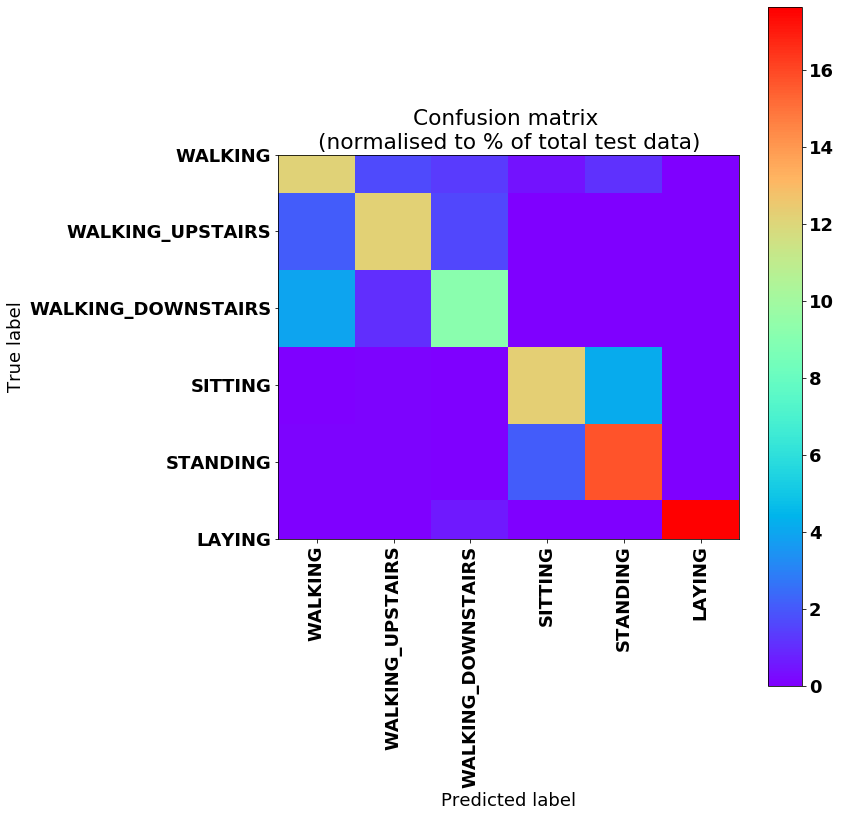

In [5]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

# Results

predictions = y_pred.argmax(1)
n_classes = 6

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [6]:
p.teardown()

Pipeline
(
	Pipeline(
	name=Pipeline,
	hyperparameters=HyperparameterSamples()
)(
		[('APICaller',
  APICaller(
	name=APICaller,
	hyperparameters=HyperparameterSamples()
))]	
)
)